# Model and Dataset Evaluation

This notebook demonstrates how to load and evaluate a model on a given dataset. It includes:

1. Parameter configuration
2. Data loading (both the dataset and any relevant AnnData objects)
3. Generating embeddings via a model
4. Visualizing embeddings with UMAP
5. Pairwise embedding analysis (e.g., similarity)
6. Metrics computation (e.g., scibEvaluator)
7. Annotation and zero-shot classification

You can adapt the parameters at the top to switch between different models and datasets.

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Imports and Configuration

In [20]:
import anndata
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from mmcontext.engine import OmicsQueryAnnotator
from mmcontext.eval import evaluate_annotation_accuracy, scibEvaluator, zero_shot_classification_roc
from mmcontext.eval.utils import create_emb_pair_dataframe
from mmcontext.pl import plot_umap, visualize_embedding_clusters
from mmcontext.pl.plotting import plot_embedding_similarity, plot_query_scores_umap
from mmcontext.pp.utils import consolidate_low_frequency_categories

# mmcontext imports
from mmcontext.utils import load_test_adata_from_hf_dataset, setup_logging

logger = setup_logging()


############################################
#           CONFIGURABLE PARAMETERS       #
############################################

SAVE_RESULTS = False  # Optionally toggle saving results
SAVE_FIGURES = False  # Optionally toggle saving figures

MODEL_NAME = "jo-mengr/mmcontext-geo7k-cellxgene3.5k-multiplets"  # Example model name
DATASET_NAME = "cellxgene_pseudo_bulk_3_5k_multiplets_natural_language_annotation"  # Example dataset name

# These keys can be adapted to your AnnData
BATCH_KEY = "assay"
LABEL_KEY = "cell_type"  # The column used for cell type labels
# Additional keys for scibEvaluator
EMBEDDING_KEYS = [
    "mmcontext_emb",
    "mmcontext_text_emb",
    "text_emb_original",
    "X_geneformer",
    "X_hvg",
    "X_pca",
    "X_scvi",
]

# Zero-shot classification function parameters
ZERO_SHOT_LABEL_KEY = LABEL_KEY
ZERO_SHOT_EMB_KEY = "mmcontext_emb"
ZERO_SHOT_TEXT_TEMPLATE = "A sample of {} from a healthy individual"

logger.info("Configuration parameters set.")

2025-02-24 13:44:08,218 - root - INFO - Configuration parameters set.


## 2. Data Loading

In [21]:
logger.info("Loading dataset from HuggingFace...")
dataset = load_dataset(f"jo-mengr/{DATASET_NAME}")

logger.info("Splitting to test subset...")
test_dataset = dataset["train"]

logger.info("Loading model...")
model = SentenceTransformer(MODEL_NAME)

logger.info("Loading AnnData from dataset...")
adata = load_test_adata_from_hf_dataset(test_dataset)

logger.info("Ensuring batch_key is categorical...")
adata.obs[BATCH_KEY] = adata.obs[BATCH_KEY].astype("category")

logger.info("Data loading complete.")
adata

2025-02-24 13:44:11,846 - root - INFO - Loading dataset from HuggingFace...
2025-02-24 13:44:14,026 - root - INFO - Splitting to test subset...
2025-02-24 13:44:14,027 - root - INFO - Loading model...
2025-02-24 13:44:14,031 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-24 13:44:14,031 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: jo-mengr/mmcontext-geo7k-cellxgene3.5k-multiplets
2025-02-24 13:44:15,343 - mmcontext.pp.MMContextProcessor - INFO - Initialized PrecomputedProcessor. Retrieval mode: numpy. Metadata from AnnData obsm_key: X_scvi.
2025-02-24 13:44:15,643 - root - INFO - Loading AnnData from dataset...
2025-02-24 13:44:24,435 - mmcontext.utils - INFO - File is a valid .h5ad file.
2025-02-24 13:44:25,984 - root - INFO - Ensuring batch_key is categorical...
2025-02-24 13:44:25,985 - root - INFO - Data loading complete.


AnnData object with n_obs × n_vars = 3150 × 22085
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', '

In [5]:
# If the dataset has "pairs" in the same, filter the label column for == 1.0
if "pairs" in DATASET_NAME:
    test_dataset = test_dataset.filter(lambda x: x[LABEL_KEY] == 1.0)

## 3. Generate Embeddings

We generate:

- `mmcontext_emb` from the omics data
- `mmcontext_text_emb` from the text annotation

In [25]:
logger.info("Generating omics embeddings...")
omics_embeddings = model.encode(test_dataset["anndata_ref"])

logger.info("Generating text embeddings with pre-trained multi-modal model...")
text_annotations = adata.obs["natural_language_annotation"].values.tolist()
text_embeddings = model.encode(text_annotations)
logger.info("Generating text embeddings with original text model...")
text_encoder_name = model[0].text_encoder_name
text_model = SentenceTransformer(text_encoder_name)
text_embeddings_original = text_model.encode(text_annotations)

logger.info("Storing embeddings in AnnData...")
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["text_emb_original"] = text_embeddings_original

logger.info("Embedding generation complete.")
adata

2025-02-24 13:48:29,594 - root - INFO - Generating omics embeddings...


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-02-24 13:48:55,447 - root - INFO - Generating text embeddings...


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-02-24 13:49:00,749 - root - INFO - Storing embeddings in AnnData...
2025-02-24 13:49:00,749 - root - INFO - Embedding generation complete.


AnnData object with n_obs × n_vars = 3150 × 22085
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', '

## 4. UMAP Visualization

Here, we visualize one of the embeddings (e.g., `mmcontext_text_emb`) with UMAP. We also remove low-frequency categories for better clarity in the plot.

2025-02-24 12:42:40,639 - root - INFO - Consolidating low-frequency categories...
2025-02-24 12:42:40,643 - root - INFO - Plotting UMAP...
2025-02-24 12:42:40,644 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-24 12:42:40,644 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

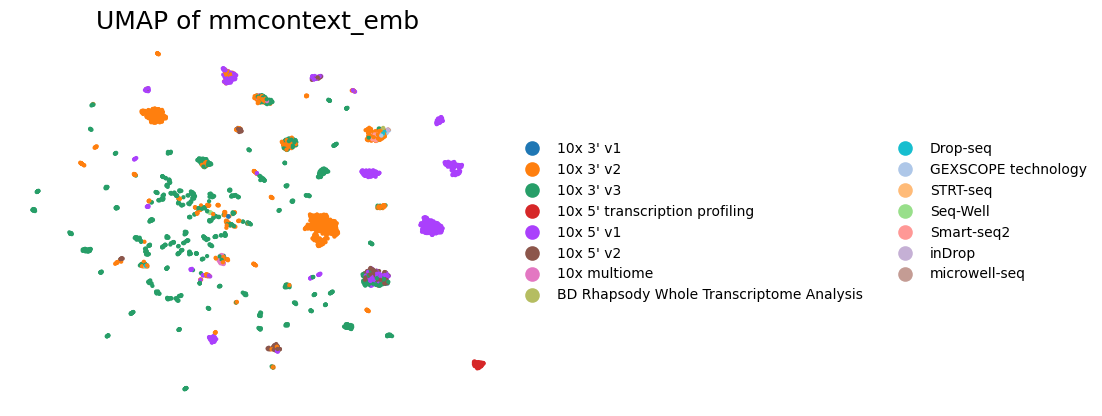

2025-02-24 12:42:45,214 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [7]:
logger.info("Consolidating low-frequency categories...")
adata_cut = consolidate_low_frequency_categories(adata, [LABEL_KEY], threshold=10)

# The color_key can be changed to anything in adata.obs, e.g. BATCH_KEY or LABEL_KEY.
color_key = BATCH_KEY

logger.info("Plotting UMAP...")
plot_umap(adata_cut, color_key=color_key, embedding_key="mmcontext_emb")

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("umap_visualization.png", dpi=150)
    logger.info("UMAP plot saved to umap_visualization.png")

## 5. Pairwise Embedding Analysis

We use `create_emb_pair_dataframe` to create a paired DataFrame of two embeddings (omics vs text). Then:

- `visualize_embedding_clusters` to see how clusters form in a joint space.
- `plot_embedding_similarity` to examine similarity distributions for subsets.

2025-02-24 12:42:45,252 - root - INFO - Creating embedding pair dataframe...
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base_row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-02-24 12:42:45,270 - mmcontext.eval.utils - INFO - Created a DataFrame with 400 rows (2 per pair).
2025-02-24 12:42:45,271 - root - INFO - Visualizing embedding clusters with UMAP...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


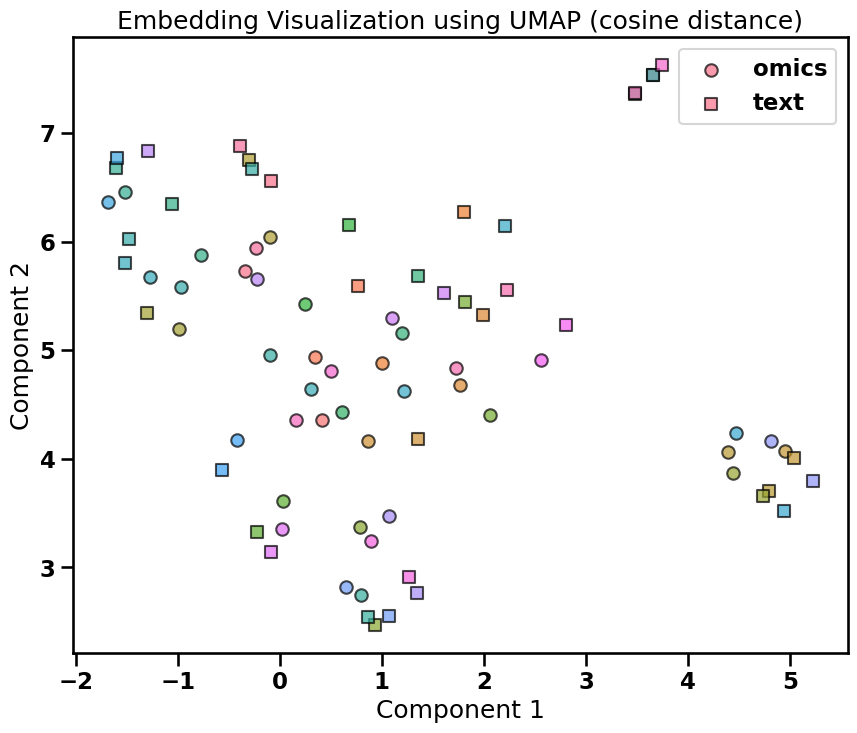

In [8]:
logger.info("Creating embedding pair dataframe...")
emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=200,
    label_keys=[BATCH_KEY, LABEL_KEY],
)

logger.info("Visualizing embedding clusters with UMAP...")
visualize_embedding_clusters(
    emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42, n_samples=40
)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("emb_clusters.png", dpi=150)
    logger.info("Embedding clusters plot saved to emb_clusters.png")

2025-02-24 12:42:47,151 - root - INFO - Plot embedding similarity with subset=10...


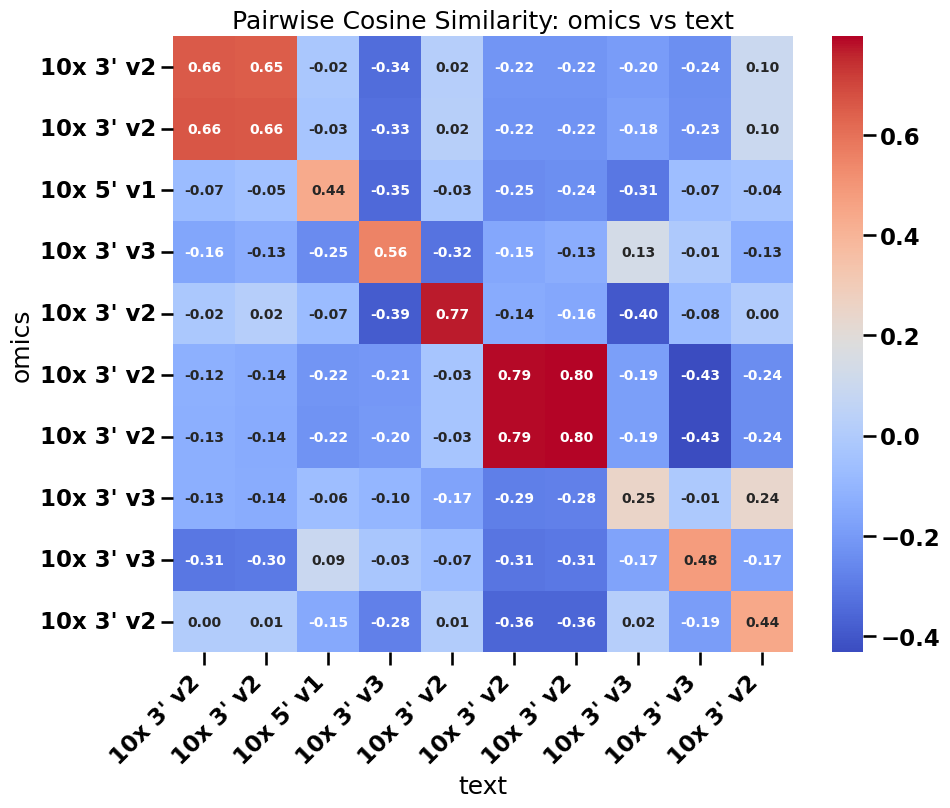

2025-02-24 12:42:47,326 - root - INFO - Plot embedding similarity with subset=10 using cell_type...


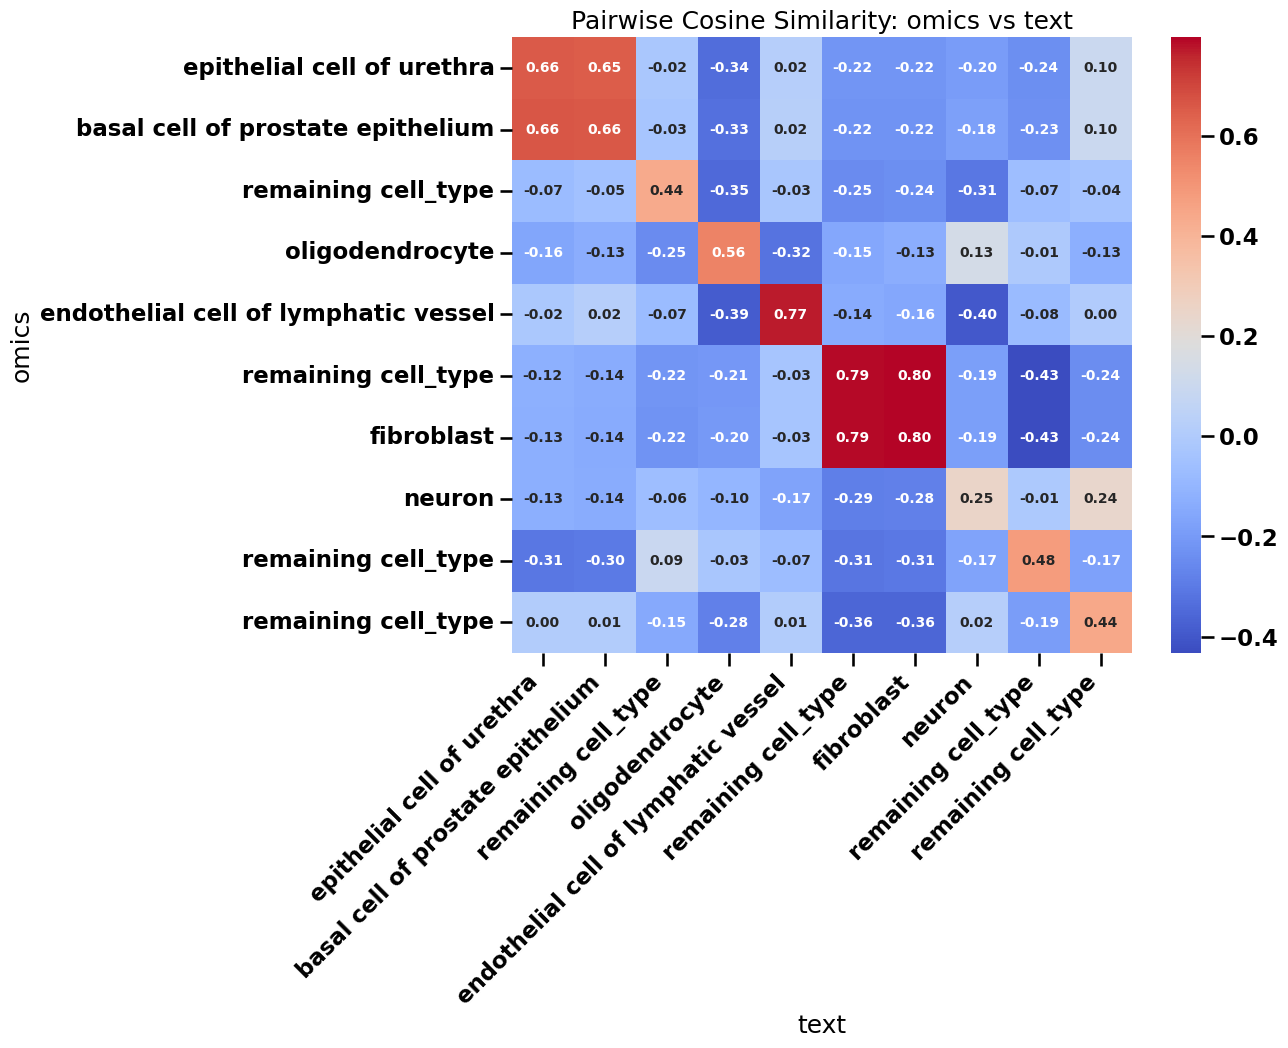

In [9]:
logger.info("Plot embedding similarity with subset=10...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=BATCH_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_batch.png", dpi=150)
    logger.info("Similarity plot (subset=10, batch) saved.")

logger.info("Plot embedding similarity with subset=10 using cell_type...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=10, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset10_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=10, cell_type) saved.")

If you want a larger subset for the similarity visualization (e.g., 200 samples):

2025-02-24 12:42:47,548 - root - INFO - Plot embedding similarity with subset=200...


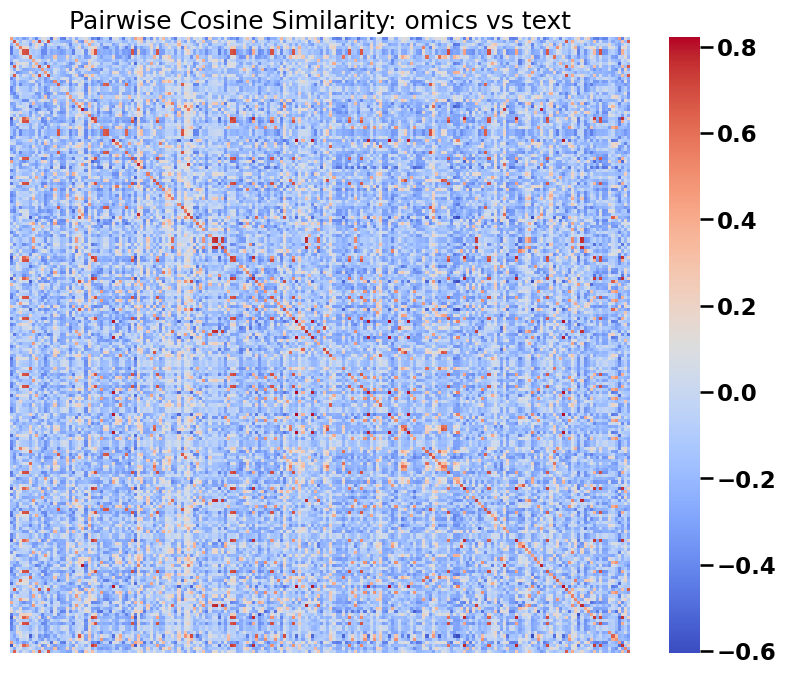

In [10]:
# Example: subset of 200
logger.info("Plot embedding similarity with subset=200...")
plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", n_samples=200, label_key=LABEL_KEY)

if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("similarity_subset200_celltype.png", dpi=150)
    logger.info("Similarity plot (subset=200, cell_type) saved.")

## 6. scibEvaluator

We can use scibEvaluator for evaluating batch integration and bio-conservation metrics (Luecken et al.).

In [11]:
EMBEDDING_KEYS

['mmcontext_emb',
 'mmcontext_text_emb',
 'X_geneformer',
 'X_hvg',
 'X_pca',
 'X_scvi']

In [13]:
# from mmcontext.pp.utils import remove_zero_variance_cells, remove_zero_variance_genes
# adata = remove_zero_variance_genes(adata)
# adata = remove_zero_variance_cells(adata)

In [18]:
logger.info("Initializing scibEvaluator...")
evaluator = scibEvaluator(
    adata=adata,
    batch_key=BATCH_KEY,
    label_key=LABEL_KEY,
    embedding_key=EMBEDDING_KEYS,
    n_top_genes=5000,
    max_cells=5000,
)

logger.info("Running scibEvaluator...")
res = evaluator.evaluate()
res_df = pd.DataFrame(res)
res_df

2025-02-24 13:27:09,587 - root - INFO - Initializing scibEvaluator...
2025-02-24 13:27:09,588 - root - INFO - Running scibEvaluator...
2025-02-24 13:27:09,589 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
2025-02-24 13:27:09,665 - mmcontext.eval.evaluate_scib - INFO - Reducing data to 5000 top genes using HVG selection...


HVG


2025-02-24 13:27:09,925 - mmcontext.eval.evaluate_scib - ERROR - Error in data reduction: Bin edges must be unique: Index([               -inf, 0.39919804073898685, 0.39919804073898685,
       0.39919804073898685, 0.39919804073898685, 0.39919804073898685,
       0.39919804073898685,  0.5756974958960753,  0.5756974958960753,
        0.5756974958960753,  0.7757122371921429,  0.8773168949912779,
        1.2276178610091988,  1.4685043534458675,  1.6215412116086867,
        1.8923567847834935,  2.3473608491173854,  3.4003830735601768,
          3.92289447422545,   6.055016916799168,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
2025-02-24 13:27:09,926 - mmcontext.eval.evaluate_scib - ERROR - Using full data for metrics computation.


Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.4711601865221807
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.47157033541159016
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.4738310301408348
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.4717984300217056
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.4721067359050472
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.47219519941869137
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.4734923687237294
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.47468994489191607
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.47518646899345995
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.47478517494166
optimised clustering against cell_type
optimal cluster resolution: 1.8
optimal score: 0.47518646899345995
isolated labels: no more than 1 batches per label
isolated labels: ['activated CD4-positive, alpha-beta T cell', 'central 

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


central nervous system macrophage: 0.7438465600425221
enteric smooth muscle cell: 0.5165194086458388
Cluster for iso_label_0.2 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:27:12,806 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.2, max_f1: 0.07547169811320754
Cluster for iso_label_0.4 with leiden
fibroblast of mammary gland: 0.5574768406454952
resolution: 0.4, max_f1: 0.07547169811320754
Cluster for iso_label_0.6 with leiden
glutamatergic neuron: 0.3725913323218586
resolution: 0.6, max_f1: 0.13714285714285715
Cluster for iso_label_0.8 with leiden
memory T cell: 0.7325794022426868
resolution: 0.8, max_f1: 0.14457831325301204
Cluster for iso_label_1.0 with leiden
mesodermal cell: 0.4943521692318536
resolution: 1.0, max_f1: 0.3116883116883117
Cluster for iso_label_1.2 with leiden
neural crest cell: 0.6717414078719811
resolution: 1.2, max_f1: 0.3116883116883117
Cluster for iso_label_1.4 with leiden
progenitor cell of mammary luminal epithelium: 0.5746036842987416
resolution: 1.4, max_f1: 0.147239263803681
Cluster for iso_label_1.6 with leiden
tonsil germinal center B cell: 0.5924313786238594
resolution: 1.6, max_f1: 0.4799999999999999
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:27:53,419 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:28:03,008 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'mmcontext_emb'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.584160
CD16-positive, CD56-dim natural killer cell, human          0.824479
CD4-positive helper T cell                                  0.780110
CD4-positive, alpha-beta T cell                             0.695684
CD8-positive, alpha-beta T cell                             0.761053
CD8-positive, alpha-beta memory T cell                      0.798499
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.651399
GABAergic neuron                                            0.638917
T cell                                                      0.928018
alpha-beta T cell                                           0.715688
alveolar macrophage                                         0.774188
astrocyte                                                   0.544708
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:28:06,329 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.2, max_f1: 0.2553191489361702
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.2553191489361702
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.2553191489361702
Cluster for iso_label_0.8 with leiden
activated CD4-positive, alpha-beta T cell: 0.9765903949737549
resolution: 0.8, max_f1: 0.2553191489361702
Cluster for iso_label_1.0 with leiden
central nervous system macrophage: 0.4829143062233925
enteric smooth muscle cell: 0.4836223665624857
fibroblast of mammary gland: 0.5310472194105387
glutamatergic neuron: 0.5422139652073383
resolution: 1.0, max_f1: 0.2553191489361702
Cluster for iso_label_1.2 with leiden
memory T cell: 0.974915087223053
mesodermal cell: 0.4700412154197693
resolution: 1.2, max_f1: 0.2553191489361702
neural crest cell: 0.49972768904990517
Cluster for iso_label_1.4 with leiden
progenitor cell of mammary luminal epithelium: 0.47451155818998814
tonsil germinal center B cell: 0.9800818860530853
resolution: 1.4, max_f1: 0.2553

2025-02-24 13:28:40,828 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.6259541984732825
tonsil germinal center B cell: 0.6259541984732825


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:28:42,177 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:28:51,834 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'mmcontext_text_emb'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.406311
CD16-positive, CD56-dim natural killer cell, human          0.673452
CD4-positive helper T cell                                  0.252886
CD4-positive, alpha-beta T cell                             0.270474
CD8-positive, alpha-beta T cell                             0.244192
CD8-positive, alpha-beta memory T cell                      0.637969
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.921282
GABAergic neuron                                            0.382367
T cell                                                      0.881611
alpha-beta T cell                                           0.677990
alveolar macrophage                                         0.454548
astrocyte                                                   0.937238
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.18604651162790695
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:28:55,091 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.18604651162790695
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.20689655172413793
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.20689655172413793
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.20689655172413793
Cluster for iso_label_1.2 with leiden
activated CD4-positive, alpha-beta T cell: 0.8568503856658936
resolution: 1.2, max_f1: 0.20689655172413793
Cluster for iso_label_1.4 with leiden
central nervous system macrophage: 0.4995246377948206
enteric smooth muscle cell: 0.5376727879047394
resolution: 1.4, max_f1: 0.20689655172413793
Cluster for iso_label_1.6 with leiden
fibroblast of mammary gland: 0.6050123274326324
glutamatergic neuron: 0.44151879847049713
resolution: 1.6, max_f1: 0.20689655172413793
Cluster for iso_label_1.8 with leiden
memory T cell: 0.9034779071807861
mesodermal cell: 0.5406942516565323
neural crest cell: 0.5112828388810158
resolution: 1.8, max_f1: 0.2553191489361702
Cluster for is

2025-02-24 13:29:22,808 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:29:24,456 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:29:34,079 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_geneformer'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.496847
CD16-positive, CD56-dim natural killer cell, human          0.630856
CD4-positive helper T cell                                  0.594808
CD4-positive, alpha-beta T cell                             0.385214
CD8-positive, alpha-beta T cell                             0.342580
CD8-positive, alpha-beta memory T cell                      0.684687
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.924674
GABAergic neuron                                            0.739902
T cell                                                      0.910814
alpha-beta T cell                                           0.847368
alveolar macrophage                                         0.844105
astrocyte                                                   0.922297
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.04195804195804196
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:29:39,147 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.04195804195804196
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.07999999999999999
Cluster for iso_label_0.8 with leiden
activated CD4-positive, alpha-beta T cell: 0.7341481894254684
resolution: 0.8, max_f1: 0.07999999999999999
Cluster for iso_label_1.0 with leiden
central nervous system macrophage: 0.6104572266340256
resolution: 1.0, max_f1: 0.07973421926910298
Cluster for iso_label_1.2 with leiden
enteric smooth muscle cell: 0.5924251526594162
fibroblast of mammary gland: 0.5282766036689281
resolution: 1.2, max_f1: 0.6857142857142856
Cluster for iso_label_1.4 with leiden
glutamatergic neuron: 0.4190463200211525
memory T cell: 0.4969219914637506
resolution: 1.4, max_f1: 0.1702127659574468
Cluster for iso_label_1.6 with leiden
mesodermal cell: 0.5191191509366035
resolution: 1.6, max_f1: 0.8275862068965517
Cluster for iso_label_1.8 with leiden
neural crest cell: 0.6363315433263779
progenitor cell of mammary luminal epithelium: 0.5149888964369

2025-02-24 13:30:21,691 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:30:23,061 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:30:32,993 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_hvg'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.909684
CD16-positive, CD56-dim natural killer cell, human          0.839618
CD4-positive helper T cell                                  0.786010
CD4-positive, alpha-beta T cell                             0.826034
CD8-positive, alpha-beta T cell                             0.850851
CD8-positive, alpha-beta memory T cell                      0.849724
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.811513
GABAergic neuron                                            0.755079
T cell                                                      0.922015
alpha-beta T cell                                           0.841401
alveolar macrophage                                         0.772724
astrocyte                                                   0.677163
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.01972062448644207
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.026002166847237267
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.7499999999999999
Cluster for iso_label_0.8 with leiden
activated CD4-positive, alpha-beta T cell: 0.5631633060423187
resolution: 0.8, max_f1: 0.7499999999999999
Cluster for iso_label_1.0 with leiden
central nervous system macrophage: 0.557692954715804
resolution: 1.0, max_f1: 0.7499999999999999
Cluster for iso_label_1.2 with leiden
enteric smooth muscle cell: 0.6130322166987674
fibroblast of mammary gland: 0.46918235423680055
resolution: 1.2, max_f1: 0.7499999999999999
Cluster for iso_label_1.4 with leiden
glutamatergic neuron: 0.4444284046687798
resolution: 1.4, max_f1: 0.10389610389610389
Cluster for iso_label_1.6 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:30:44,523 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


memory T cell: 0.49829505349540476
resolution: 1.6, max_f1: 0.7499999999999999
Cluster for iso_label_1.8 with leiden
mesodermal cell: 0.5434556637598278
resolution: 1.8, max_f1: 0.7272727272727273
Cluster for iso_label_2.0 with leiden
neural crest cell: 0.606419510733348
resolution: 2.0, max_f1: 0.7499999999999999
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.7499999999999999
progenitor cell of mammary luminal epithelium: 0.5837215259532933
activated CD4-positive, alpha-beta T cell: 0.7499999999999999
tonsil germinal center B cell: 0.5754928253799343
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.11670020120724346
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.7868852459016393
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.8125
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.8125
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.8125
Cluster for iso_label_1.2 

2025-02-24 13:31:26,978 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:31:30,971 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:31:38,308 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_pca'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.734648
CD16-positive, CD56-dim natural killer cell, human          0.952722
CD4-positive helper T cell                                  0.909024
CD4-positive, alpha-beta T cell                             0.751249
CD8-positive, alpha-beta T cell                             0.807241
CD8-positive, alpha-beta memory T cell                      0.900498
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.882964
GABAergic neuron                                            0.854064
T cell                                                      0.957835
alpha-beta T cell                                           0.911829
alveolar macrophage                                         0.893185
astrocyte                                                   0.767161
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:31:42,915 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.2, max_f1: 0.07547169811320754
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.07547169811320754
Cluster for iso_label_0.6 with leiden
central nervous system macrophage: 0.7438465600425221
resolution: 0.6, max_f1: 0.13714285714285715
Cluster for iso_label_0.8 with leiden
enteric smooth muscle cell: 0.5165194086458388
resolution: 0.8, max_f1: 0.14457831325301204
Cluster for iso_label_1.0 with leiden
fibroblast of mammary gland: 0.5574768406454952
resolution: 1.0, max_f1: 0.3116883116883117
Cluster for iso_label_1.2 with leiden
glutamatergic neuron: 0.3725913323218586
resolution: 1.2, max_f1: 0.3116883116883117
Cluster for iso_label_1.4 with leiden
memory T cell: 0.7325794022426868
resolution: 1.4, max_f1: 0.147239263803681
Cluster for iso_label_1.6 with leiden
mesodermal cell: 0.4943521692318536
neural crest cell: 0.6717414078719811
resolution: 1.6, max_f1: 0.4799999999999999
Cluster for iso_label_1.8 with leiden
progenitor cell of mammary luminal epitheli

2025-02-24 13:32:22,734 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'


optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.7352941176470589
tonsil germinal center B cell: 0.7352941176470589


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:32:24,135 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:32:34,083 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'X_scvi'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.584160
CD16-positive, CD56-dim natural killer cell, human          0.824479
CD4-positive helper T cell                                  0.780110
CD4-positive, alpha-beta T cell                             0.695684
CD8-positive, alpha-beta T cell                             0.761053
CD8-positive, alpha-beta memory T cell                      0.798499
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.651399
GABAergic neuron                                            0.638917
T cell                                                      0.928018
alpha-beta T cell                                           0.715688
alveolar macrophage                                         0.774188
astrocyte                                                   0.544708
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


Cluster for iso_label_0.2 with leiden
activated CD4-positive, alpha-beta T cell: 0.7151483297348022
resolution: 0.2, max_f1: 0.05417607223476298
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:32:38,906 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.1301775147928994
Cluster for iso_label_0.6 with leiden
central nervous system macrophage: 0.7535456120967865
resolution: 0.6, max_f1: 0.12222222222222223
Cluster for iso_label_0.8 with leiden
enteric smooth muscle cell: 0.46902219764888287
resolution: 0.8, max_f1: 0.1301775147928994
Cluster for iso_label_1.0 with leiden
fibroblast of mammary gland: 0.5719555541872978
resolution: 1.0, max_f1: 0.12359550561797752
Cluster for iso_label_1.2 with leiden
glutamatergic neuron: 0.42932185530662537
resolution: 1.2, max_f1: 0.15
Cluster for iso_label_1.4 with leiden
memory T cell: 0.7183624804019928
resolution: 1.4, max_f1: 0.22641509433962262
Cluster for iso_label_1.6 with leiden
mesodermal cell: 0.49392702244222164
resolution: 1.6, max_f1: 0.25263157894736843
Cluster for iso_label_1.8 with leiden
neural crest cell: 0.6241541281342506
progenitor cell of mammary luminal epithelium: 0.5681701228022575
resolution: 1.8, max_f1: 0.1568627450980392
Cluster for iso_label_2.0

2025-02-24 13:33:16,272 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:33:17,916 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'
2025-02-24 13:33:27,444 - mmcontext.eval.evaluate_scib - INFO - Computing metrics on embedding 'biobert_text_emb'...


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.617886
CD16-positive, CD56-dim natural killer cell, human          0.847079
CD4-positive helper T cell                                  0.865084
CD4-positive, alpha-beta T cell                             0.614150
CD8-positive, alpha-beta T cell                             0.751720
CD8-positive, alpha-beta memory T cell                      0.755368
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.641206
GABAergic neuron                                            0.618667
T cell                                                      0.936266
alpha-beta T cell                                           0.731708
alveolar macrophage                                         0.788034
astrocyte                                                   0.606210
basal c

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/evaluate_scib.py:180: UserWarning: Overwriting existing key cluster in adata.obs
  me.cluster_optimal_resolution(adata, cluster_key=cluster_key, label_key=self.label_key)


resolution: 0.2, max_f1: 0.25
Cluster for iso_label_0.4 with leiden


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:33:32,301 - mmcontext.eval.evaluate_scib - ERROR - Error computing cLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


resolution: 0.4, max_f1: 0.25
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.25
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.25
Cluster for iso_label_1.0 with leiden
activated CD4-positive, alpha-beta T cell: 0.7143998146057129
resolution: 1.0, max_f1: 0.25
Cluster for iso_label_1.2 with leiden
central nervous system macrophage: 0.6231575459241867
resolution: 1.2, max_f1: 0.25
Cluster for iso_label_1.4 with leiden
enteric smooth muscle cell: 0.6170102134346962
fibroblast of mammary gland: 0.5633188784122467
resolution: 1.4, max_f1: 0.25
Cluster for iso_label_1.6 with leiden
glutamatergic neuron: 0.5205417945981026
resolution: 1.6, max_f1: 0.25
Cluster for iso_label_1.8 with leiden
memory T cell: 0.7690583169460297
resolution: 1.8, max_f1: 0.25
Cluster for iso_label_2.0 with leiden
mesodermal cell: 0.5979896485805511
neural crest cell: 0.542599257081747
resolution: 2.0, max_f1: 0.25
optimised clustering against cell_type
optimal cluster resolution: 

2025-02-24 13:34:09,060 - mmcontext.eval.evaluate_scib - ERROR - Error computing PCR: pcr_comparison() got multiple values for argument 'adata_pre'
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-02-24 13:34:10,432 - mmcontext.eval.evaluate_scib - ERROR - Error computing iLISI: [Errno 8] Exec format error: '/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/scib/knn_graph/knn_graph.o'


mean silhouette per group:                                                     silhouette_score
group                                                               
B cell                                                      0.814220
CD16-positive, CD56-dim natural killer cell, human          0.860286
CD4-positive helper T cell                                  0.918577
CD4-positive, alpha-beta T cell                             0.774971
CD8-positive, alpha-beta T cell                             0.817826
CD8-positive, alpha-beta memory T cell                      0.817005
CD8-positive, alpha-beta memory T cell, CD45RO-...          0.899577
GABAergic neuron                                            0.748037
T cell                                                      0.941246
alpha-beta T cell                                           0.881088
alveolar macrophage                                         0.884928
astrocyte                                                   0.838128
basal c

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Graph_Connectivity,Silhouette_Batch,Batch_Integration_Score,Overall_Score
0,,5000,raw,0.092166,0.475186,0.445097,0.604990,0.321283,0.387745,0.426376,0.738562,0.582469,0.465635
1,,5000,embedding_mmcontext_emb,0.127771,0.476341,0.358676,0.641567,0.314249,0.383721,0.428420,0.567974,0.498197,0.429511
2,,5000,embedding_mmcontext_text_emb,0.101819,0.473754,0.392210,0.620730,0.333997,0.384502,0.483091,0.661907,0.572499,0.459701
3,,5000,embedding_X_geneformer,0.203830,0.558432,0.475678,0.566057,0.377728,0.436345,0.748104,0.810205,0.779154,0.573469
4,,5000,embedding_X_hvg,0.134971,0.513560,0.467828,0.545488,0.373756,0.407120,0.703267,0.857192,0.780229,0.556364
5,,5000,embedding_X_pca,0.184122,0.524151,0.445097,0.604990,0.321283,0.415929,0.616455,0.738562,0.677509,0.520561
6,,5000,embedding_X_scvi,0.179611,0.511636,0.425088,0.592985,0.249869,0.391838,0.591115,0.750371,0.670743,0.503400
7,,5000,embedding_biobert_text_emb,0.118671,0.442953,0.481855,0.607272,0.308072,0.391764,0.737718,0.844679,0.791198,0.551538


## 7. Annotation and Query

We can annotate and query our omics data using `OmicsQueryAnnotator`.

2025-02-24 14:03:08,755 - root - INFO - Annotating omics data...
2025-02-24 14:03:08,764 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-02-24 14:03:10,207 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-24 14:03:10,208 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-24 14:03:10,210 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-24 14:03:11,690 - root - INFO - Plotting annotated data...
2025-02-24 14:03:11,691 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-24 14:03:11,691 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

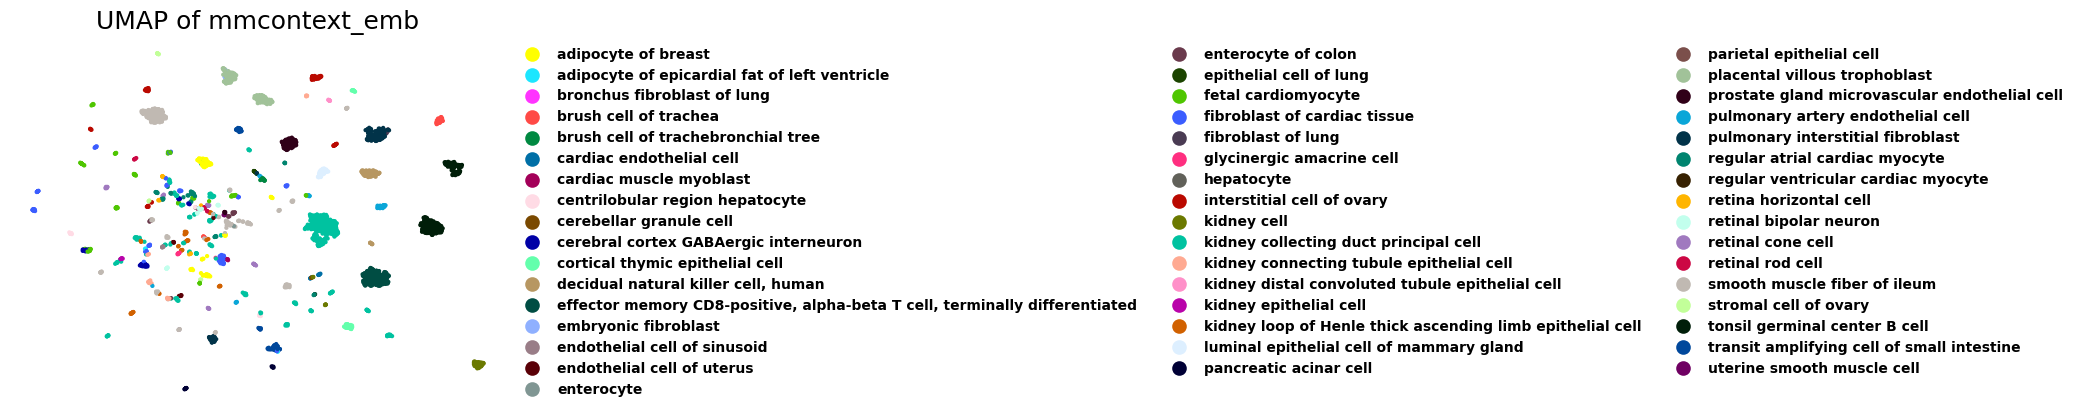

2025-02-24 14:03:14,364 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.
2025-02-24 14:03:14,365 - root - INFO - Evaluating annotation accuracy...
2025-02-24 14:03:14,365 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'cell_type' and 'best_label'. Accuracy = 3.24%
2025-02-24 14:03:14,366 - root - INFO - Accuracy of annotation: 0.03238095238095238


In [29]:
logger.info("Annotating omics data...")
annotator = OmicsQueryAnnotator(model)

# Suppose we have some labels to annotate, e.g. from an external source
labels = adata.obs[LABEL_KEY].values.tolist()
annotator.annotate_omics_data(adata, labels, text_template=ZERO_SHOT_TEXT_TEMPLATE)

logger.info("Plotting annotated data...")
plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

logger.info("Evaluating annotation accuracy...")
score = evaluate_annotation_accuracy(
    adata,
    true_key=LABEL_KEY,  # or whichever key is ground truth for your scenario
    inferred_key="best_label",
)
logger.info(f"Accuracy of annotation: {score}")

### Example: Query with text
You can query the dataset with text prompts and then visualize the result.

In [33]:
adata

AnnData object with n_obs × n_vars = 3150 × 22085
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type', '

2025-02-24 14:07:33,148 - root - INFO - Querying dataset for 'This is a immune cell'...
2025-02-24 14:07:33,148 - mmcontext.engine.query_annotate - INFO - Encoding the queries.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-24 14:07:33,189 - mmcontext.engine.query_annotate - INFO - Computing cosine similarity between queries and omics data.
2025-02-24 14:07:33,196 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-24 14:07:33,196 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-24 14:07:33,199 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-24 14:07:33,254 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-24 14:07:33,254 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_scvi'.


<Figure size 800x800 with 0 Axes>

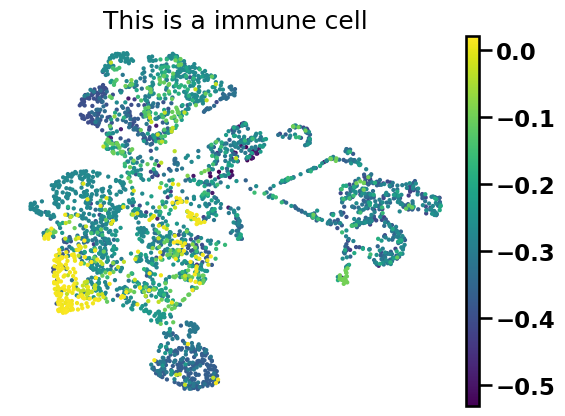

2025-02-24 14:07:35,293 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [37]:
# Example usage
qa = annotator  # if the OmicsQueryAnnotator has a method query_with_text
logger.info("Querying dataset for 'This is a immune cell'...")
qa.query_with_text(adata, ["This is a immune cell"])

# Visualize
plot_query_scores_umap(adata, embedding_key="X_scvi")
if SAVE_FIGURES:
    import matplotlib.pyplot as plt

    plt.savefig("query_scores_umap.png", dpi=150)
    logger.info("Query scores UMAP saved.")

## 8. Zero-Shot Classification ROC

Below is a function to compute a ROC-AUC for cell-type prediction (or any label) in a zero-shot manner.

In [40]:
logger.info("Computing zero-shot classification ROC...")
macro_auc, auc_details = zero_shot_classification_roc(
    adata,
    model,
    label_key=ZERO_SHOT_LABEL_KEY,
    emb_key=ZERO_SHOT_EMB_KEY,
    text_template=ZERO_SHOT_TEXT_TEMPLATE,
    device="cpu",
)
logger.info(f"Macro AUC: {macro_auc}")
logger.info(f"Detail per label: {auc_details}")

2025-02-24 14:09:34,480 - root - INFO - Computing zero-shot classification ROC...
2025-02-24 14:09:34,484 - mmcontext.eval.classification_roc - INFO - Building text queries for each label...
2025-02-24 14:09:34,484 - mmcontext.eval.classification_roc - INFO - Embedding 280 label queries...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-02-24 14:09:34,847 - mmcontext.eval.classification_roc - INFO - Retrieving sample embeddings from adata.obsm[mmcontext_emb]...
2025-02-24 14:09:34,847 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-24 14:09:34,848 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-24 14:09:34,849 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu
2025-02-24 14:09:35,064 - mmcontext.eval.classification_roc - INFO - Zero-shot cell-type prediction macro-AUC: 0.7745
2025-02-24 14:09:35,065 - root - INFO - Macro AUC: 0.7744650397084576
2025-02-24 14:09:35,065 - root - INFO - Detail per label: {'B cell': 0.6573416116374773, 'B-1a B cell': 0.523779260671539, 'B-2 B cell': 0.7262623054938075, 'BEST4+ intestinal epithelial cell, human': 0.9148936170212766, 'Bergmann glial cell': 0.9053667831057479, 'CD16-negative, CD56-bright natural killer cell, human': 0.7841343093570974, 'CD16-positive, CD56-dim natural killer cell, hu

## 9. (Optional) Saving Notebook Outputs

If you wish to programmatically save this notebook (e.g., for batch runs or CI/CD), you can use a dedicated library like `nbformat` or `papermill`. Here's a small snippet as an example (commented out by default).

In [ ]:
# Uncomment and adapt if you want to save the executed notebook programmatically
# import nbformat
# from nbformat.v4 import new_notebook
# from nbconvert.preprocessors import ExecutePreprocessor
# from nbconvert import HTMLExporter
#
# if SAVE_RESULTS:
#     logger.info("Saving notebook...")
#     with open("evaluation_notebook.ipynb", "r") as f:
#         nb = nbformat.read(f, as_version=4)
#     ep = ExecutePreprocessor(timeout=600)
#     ep.preprocess(nb, {'metadata': {'path': './'}})
#     with open("evaluation_notebook_executed.ipynb", "w") as f:
#         nbformat.write(nb, f)
#
#     # Optionally export to HTML
#     html_exporter = HTMLExporter()
#     body, _ = html_exporter.from_notebook_node(nb)
#     with open("evaluation_notebook_executed.html", "w") as f:
#         f.write(body)
#
#     logger.info("Notebook saved as evaluation_notebook_executed.ipynb and HTML version.")
